In [1]:
import numpy as np
# import cv2 as cv
import matplotlib.pyplot as plt
# import time

In [132]:
# define a general gradient descent method
def gradient_descent(loss_func, opt_params):
    """
    Learn a set of parameters using gradient descent.

    Inputs: loss_func, opt_params
    loss_func - loss function to use for training; it should only take one input which is optimization parameter
    opt_params - parameters of the training algorithm (see below)

    Outputs: Theta, stats
    Theta - parameters at the end of optimization
    stats - dictionary of various statistics computed during training to be used
            for visualization and analysis
    """

    # Optimization parameters in opt_params
    epsilon0 = opt_params['epsilon0'] # starting learning rate for GD
    epsilon_decay = opt_params['epsilon_decay'] # decay factor for GD learning rate
    epsilon_jump = opt_params['epsilon_jump'] # decay factor for GD learning rate
    num_its = opt_params['num_its'] # number of iterations to run
    Theta0 = opt_params['Theta0'] # initial value for the parameters, can be None to randomly initialize
    check_freq = opt_params['check_freq'] # how frequently to compute and print out statistics of learning
    print_checks = opt_params['print_checks'] # print info out when checkpointing
    seed = opt_params['seed'] if 'seed' in opt_params else 0

    if seed is not None:
        np.random.seed(seed)

    check_its = []
    check_times = []
    check_Thetas = []
    train_losss = []
    it_times = []
    epsilon = epsilon0
    start_t = time.time()
    Theta = Theta0
    for it in range(num_its):
        #print('new it:')
        #print('Theta = '+str(Theta))
        
        # Compute loss and its derivative with current parameter values
        E, dEdTheta = loss_func(Theta, deriv=True)
        
        #print('E = ' + str(E))
        #print('dEdTheta = ' + str(dEdTheta))
        
        # Find epsilon which decreases train loss
        epsilon *= epsilon_jump
        
        #print('epsilon = '+str(epsilon))
        
        new_E = np.inf
        while new_E > E:
            # Update parameters with the GD update
            Theta1 = Theta - epsilon * dEdTheta
            #print('Theta1 = '+str(Theta1))
            new_E = loss_func(Theta1, deriv=False)
            #print('new_E = '+str(new_E))
            epsilon *= epsilon_decay
            #print('epsilon = '+str(epsilon))

        # Replace old value of Theta with new one
        Theta = Theta1
        #print('final Theta = '+str(Theta))
        
        # Compute the norm of the entire gradient to monitor
        nrmsq_dEdTheta = np.sum(dEdTheta**2)
        
        # Restore epsilon's working value 
        epsilon /= epsilon_decay

        if it%check_freq == 0 or it+1 == num_its:
            # Periodically compute the training loss/accuracy on the _full_ dataset
            # for reference.  Note this is rarely done in practice because it isn't
            # possible or is hugely impractical.  We're just doing it here to see 
            # how it relates to the values computed with a mini-batch
            E = loss_func(Theta, deriv=False)

            check_Thetas.append(Theta)
            check_its.append(it)
            check_times.append(time.time() - start_t)
            train_losss.append(E)

            if print_checks:
                print("{:4}: eps = {:.2e};"
                      "  train loss (E) = {:5.2f};"
                      "  ||dEdTheta|| = {:5.2f}".format(it, epsilon,
                                                        E, 
                                                        np.sqrt(nrmsq_dEdTheta)))
        it_times.append(time.time() - start_t)

    stats = { 'check_its':check_its, # Iteration numbers of checkpoints
            'check_times':check_times, # wall clock time of checkpoints
            'check_Thetas':check_Thetas, # Theta values at checkpoints
            'it_times':it_times, # wall clock time of each iteration
            'train_losss':train_losss} # loss of full training set at checkpoint iterations
    
    return Theta, stats

In [90]:
def gaussian_2d(l, pos, hei, shift, sig, plott=False, deriv=False):
    """
    Create 2D Gaussian function
    Input: l, pos, hei, shift, sig, deriv
    l - tuple of x- and y- lengths of 2d map
    pos - 2x1 vector of x and y position
    hei - tuple of gaussian heights in x and y directions
    shift - tuple of x and y shifts
    sig - tuple of gaussian deviations in x and y directions
    plot - whether or not plot the 2d gaussian function
    deriv - whether or not to compute and do the derivative

    Output: if deriv: g
              else: g, dg
    g - scalar value of 2D gaussian function at (x,y)
    dg - tuple of derivatives of gaussian function w.r.t. (x,y)
    """  

    lx, ly = l
    posx, posy = pos
    heix, heiy = hei
    shiftx, shifty = shift
    sigx, sigy = sig
    
    x = np.linspace(-(lx - 1) / 2., (lx - 1) / 2., lx)
    y = np.linspace(-(ly - 1) / 2., (ly - 1) / 2., ly)
    
    gaussx = heix * np.exp(-0.5 * ((x - shiftx) ** 2) / (sigx ** 2))
    gx = np.broadcast_to([gaussx], (ly, lx))
    
    gaussy = heiy * np.exp(-0.5 * ((y - shifty) ** 2) / (sigy ** 2))
    gy = np.broadcast_to([gaussy], (lx, ly)).T
    
    g = 1 - gx * gy
    
    if plott:
        plt.figure(figsize=(6,6))
        plt.imshow(g)
        x_ticks = np.linspace(0,lx-1,5, dtype=int)
        plt.xticks(x_ticks, x[x_ticks])
        y_ticks = np.linspace(0,ly-1,5, dtype=int)
        plt.yticks(y_ticks, y[y_ticks])
        plt.plot(posx + (lx - 1) / 2, posy + (ly - 1) / 2, 'ro')
        plt.colorbar()
    
    g_pos = g[int(posy + (ly - 1) / 2)][int(posx + (lx - 1) / 2)]
    
    if deriv:
        
        dgdx = g_pos * (posx - shiftx) / (sigx ** 2)
        dgdy = g_pos * (posy - shifty) / (sigy ** 2)
        dg = np.array([dgdx, dgdy])
        
        return g_pos, dg
    else:
        return g_pos

   0: eps = 2.00e+00;  train loss (E) =  0.87;  ||dEdTheta|| =  0.38
   2: eps = 8.00e+00;  train loss (E) =  0.65;  ||dEdTheta|| =  0.25
   4: eps = 3.20e+01;  train loss (E) =  0.23;  ||dEdTheta|| =  0.06
   6: eps = 1.28e+02;  train loss (E) =  0.08;  ||dEdTheta|| =  0.01
   8: eps = 5.12e+02;  train loss (E) =  0.02;  ||dEdTheta|| =  0.00
  10: eps = 1.02e+03;  train loss (E) =  0.00;  ||dEdTheta|| =  0.00
  12: eps = 4.10e+03;  train loss (E) =  0.00;  ||dEdTheta|| =  0.00
  14: eps = 4.10e+03;  train loss (E) =  0.00;  ||dEdTheta|| =  0.00
  15: eps = 8.19e+03;  train loss (E) =  0.00;  ||dEdTheta|| =  0.00


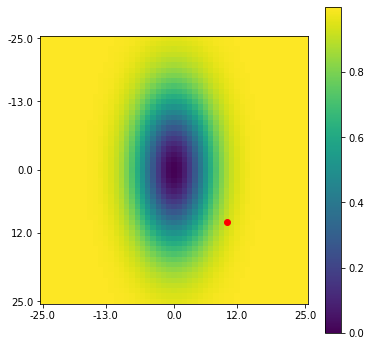

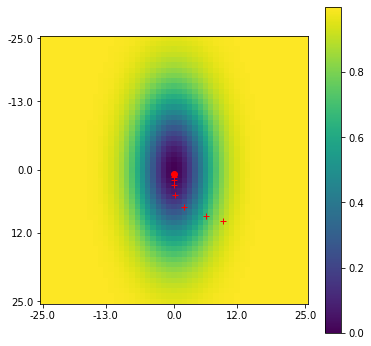

In [135]:
def gaussian_2d_wrap(pos, deriv=False, plott=False):
    """
    Wrapper for the 2D gaussian function to be used in gradient descent.
    
    Input: pos, deriv
    pos - tuple of x- and y-position of desired point in our 2D function; a.k.a. parameters of GD
    deriv - whether or not to compute and do the derivative
    
    Output: if deriv: g, dg
                else: g
    g - scalar value of gaussian function at the desired point
    dg - tuple of x- and y-derivatives of the gaussian function
    """
    
    # Create a 2D gaussian map
    l = (51, 51)
    hei = (1,1)
    shift = (0,0)
    sig = (5,10)
    
    # Return g, dg and plot if requested
    return gaussian_2d(l, pos, hei, shift, sig, plott=plott, deriv=deriv)


# plot the 2D gaussian map
pos0 = np.array([10,10])
lx, ly = 51, 51
g = gaussian_2d_wrap(pos0, deriv=False, plott=True)

# find min of the function with gradient descent
opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2,
               'num_its':16, 'check_freq':2, 'print_checks':True, 'Theta0':pos0 }
opt_pos, stats = gradient_descent(gaussian_2d_wrap, opt_params)

# visualize training process
check_poss = stats['check_Thetas']
check_xs = [x + (lx - 1) / 2 for (x,y) in check_poss]
check_ys = [y + (ly - 1) / 2 for (x,y) in check_poss]

gaussian_2d_wrap(opt_pos, deriv=False, plott=True)
plt.plot(check_xs,check_ys,'r+')